# Building a network

based off ugis22's repository https://github.com/ugis22/analysing_twitter

failed because networkx too slow (some n^3 computations)

In [1]:
#data
import pandas as pd
import numpy as np
from scipy import stats
from operator import itemgetter

#plots
import matplotlib.pyplot as plt
import seaborn as sns

#graph
import networkx as nx

In [4]:
tweets1 = pd.read_csv("../data/tweets1.csv", low_memory=False)
tweets2 = pd.read_csv("../data/tweets2.csv", low_memory=False)
tweets3 = pd.read_csv("../data/tweets3_1.csv", low_memory=False)
tweets4 = pd.read_csv("../data/tweets3_2.csv", low_memory=False)
tweets5 = pd.read_csv("../data/tweets3_3.csv", low_memory=False)

In [19]:
tweets_df = pd.concat([tweets1, tweets2, tweets3, tweets4, tweets5]).sample(100000)
tweets_df.shape

(100000, 31)

In [20]:
tweets_df.columns

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_language',
       'tweet_text', 'tweet_time', 'tweet_client_name', 'in_reply_to_userid',
       'in_reply_to_tweetid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'latitude', 'longitude',
       'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags',
       'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

In [21]:
# create second df to store important data
tweets_final = pd.DataFrame(columns = ["tweet_time", "tweetid", "userid", "in_reply_to_tweetid", "in_reply_to_userid",
                                      "retweet_userid", "retweet_tweetid", "user_mentions", "tweet_text", "user_screen_name", "follower_count"])

In [22]:
# Columns that are going to be the same
equal_columns = ["tweet_time", "tweetid", "tweet_text"]
tweets_final[equal_columns] = tweets_df[equal_columns]

In [23]:
# Get the basic information about user 
def get_basics(tweets_final):
    tweets_final["user_screen_name"] = tweets_df["user_screen_name"]
    tweets_final["userid"] = tweets_df["userid"]
    tweets_final["follower_count"] = tweets_df["follower_count"]
    
    return tweets_final

In [24]:
# Get the user mentions 
def get_usermentions(tweets_final):
    tweets_final["user_mentions"] = tweets_df["user_mentions"]
    
    return tweets_final

In [25]:
# Get retweets
def get_retweets(tweets_final):
    tweets_final["retweet_userid"] = tweets_df["retweet_userid"]
    tweets_final['retweet_tweetid'] = tweets_df['retweet_userid']
    
    return tweets_final

In [26]:
# Get the information about replies
def get_in_reply(tweets_final):
    # Just copy the 'in_reply' columns to the new dataframe
    tweets_final["in_reply_to_tweetid"] = tweets_df["in_reply_to_tweetid"]
    tweets_final["in_reply_to_userid"]= tweets_df["in_reply_to_userid"]
    
    return tweets_final

In [27]:
# Lastly fill the new dataframe with the important information
def fill_df(tweets_final):
    get_basics(tweets_final)
    get_usermentions(tweets_final)
    get_retweets(tweets_final)
    get_in_reply(tweets_final)
    
    return tweets_final

In [28]:
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["userid"], row["user_screen_name"]
    # Be careful if there is no user id
    if user[0] is None:
        return (None, None), []
    
    # The interactions are going to be a set of tuples
    interactions = set()
    
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add((row["in_reply_to_userid"],row["in_reply_to_userid"]))
    # After that, we add the interactions with retweets
    interactions.add((row["retweet_userid"],row["retweet_userid"]))
    # And later, the interactions with user mentions
    interactions.add((row["user_mentions"],row["user_mentions"]))
    
    # Discard if user id is in interactions
    interactions.discard((row["userid"], row["user_screen_name"]))
    # Discard all not existing values
    interactions.discard((None, None))
    
    # Return user and interactions
    return user, interactions

In [29]:
tweets_final = fill_df(tweets_final)

In [30]:
tweets_final = tweets_final.where((pd.notnull(tweets_final)), None)

In [31]:
graph = nx.Graph()

In [32]:
counter = 0
for index, tweet in tweets_final.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["tweetid"]

    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)
        

        graph.nodes[user_id]["name"] = user_name
        graph.nodes[int_id]["name"] = int_name

In [56]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 56690 nodes and 65264 edges present in the Graph


In [34]:
degrees = [val for (node, val) in graph.degree()]

In [35]:
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

The maximum degree of the Graph is 5597
The minimum degree of the Graph is 1


In [36]:
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")

The average degree of the nodes in the Graph is 2.3
The most frequent degree of the nodes found in the Graph is 1


In [37]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is not connected


In [38]:
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

There are 185 connected components in the Graph


In [57]:
#largest_subgraph = max(nx.connected_component_subgraphs(graph), key=len)
largest_subgraph = max((graph.subgraph(c) for c in nx.connected_components(graph)), key=len)

In [58]:
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")

There are 55904 nodes and 64657 edges present in the largest component of the Graph


In [47]:
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is connected


In [48]:
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

The average clustering coefficient is 0.001877268674828346 in the largest subgraph


KeyboardInterrupt: 

In [ ]:
print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

In [49]:
graph_centrality = nx.degree_centrality(largest_subgraph)

In [50]:
max_de = max(graph_centrality.items(), key=itemgetter(1))

In [51]:
graph_closeness = nx.closeness_centrality(largest_subgraph)

KeyboardInterrupt: 

In [ ]:
max_clo = max(graph_closeness.items(), key=itemgetter(1))

In [ ]:
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)

In [ ]:
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

In [ ]:
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

In [ ]:
#TODO
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange', 'red']
central_nodes = ['393852070', '2896294831']

In [60]:
pos = nx.circular_layout(largest_subgraph)

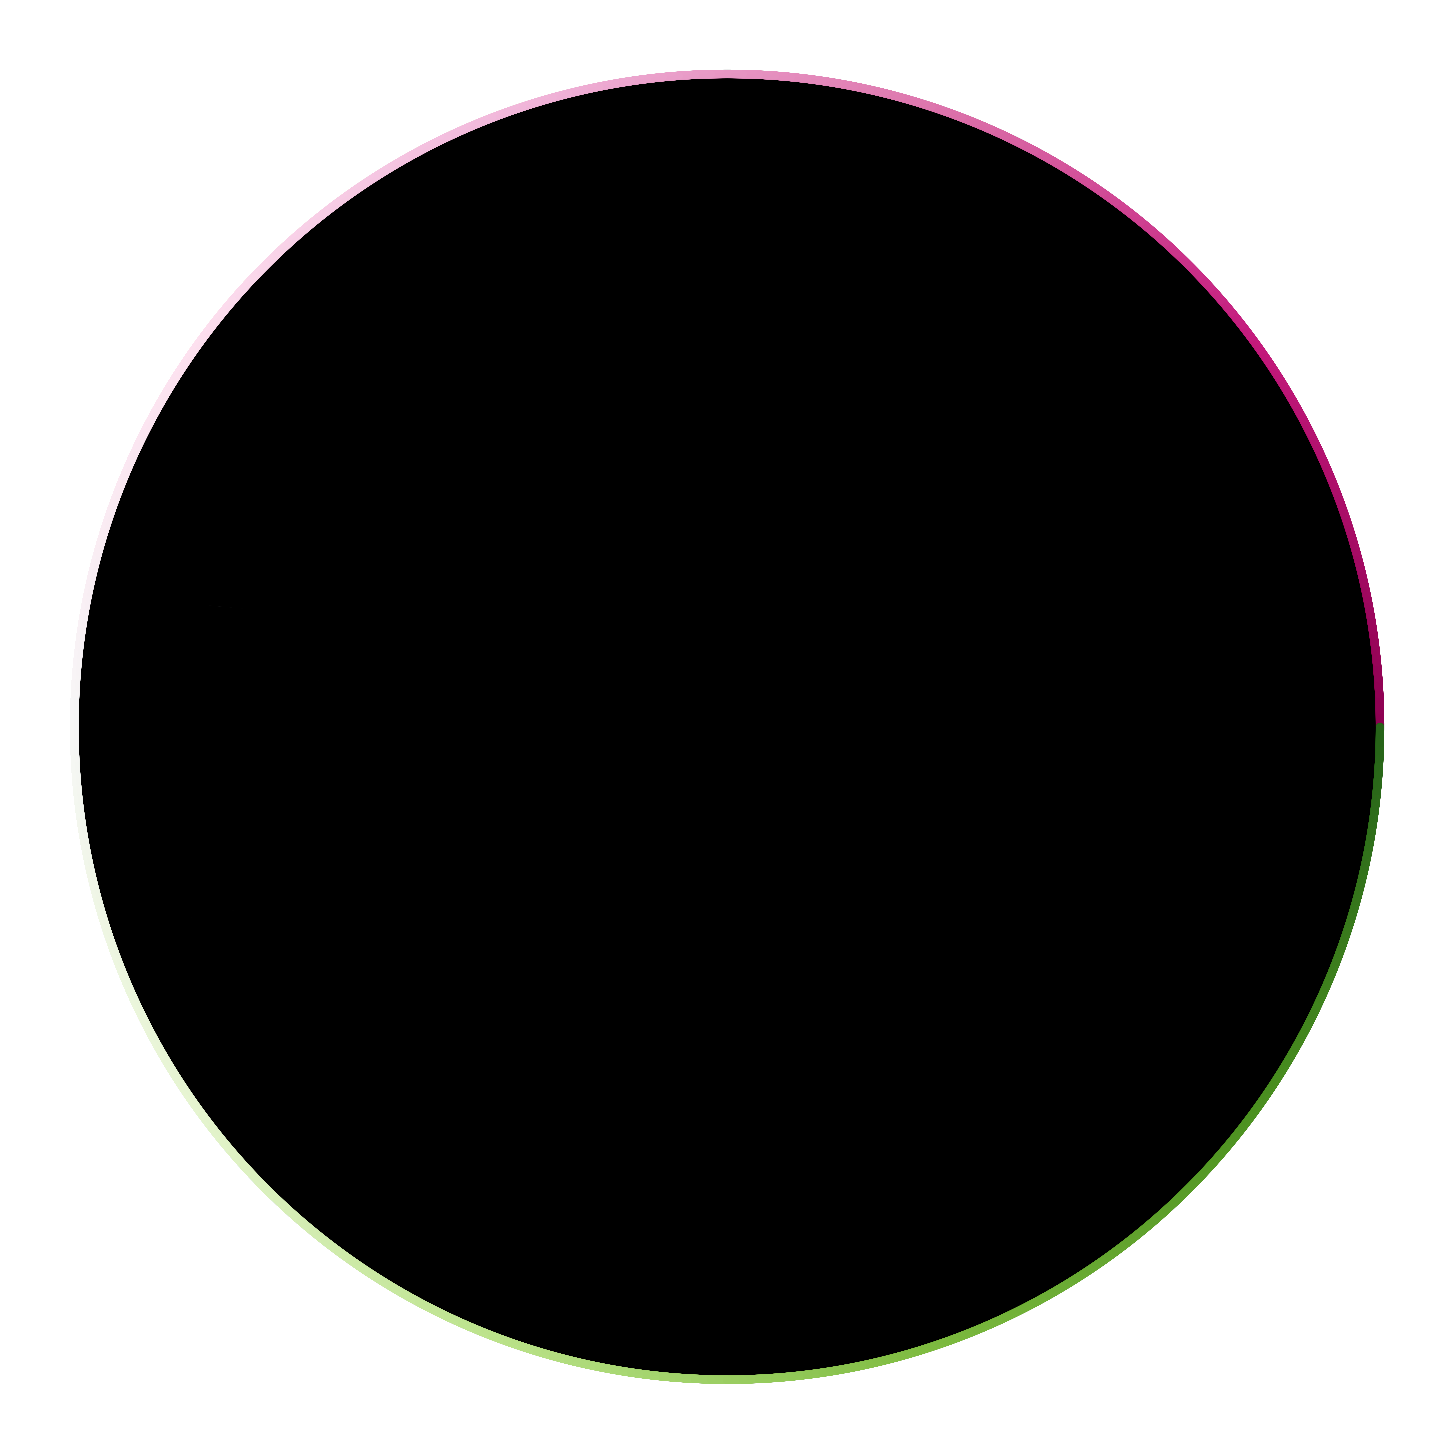

In [62]:
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(55904), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.1, node_size=60, alpha=0.6, with_labels=False)
#nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.savefig('graphfinal.png')
plt.show()